**Author: Anupriya Tripathi (a3tripat@ucsd.edu)**

In [1]:
import pandas as pd
import biom
import itertools
import seaborn as sns
import skbio.stats.distance as ssd
from scipy.stats import kruskal
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# import biom table as artifact
! qiime tools import \
  --input-path ../reference-hit9k-wtax.biom \
  --type 'FeatureTable[Frequency]' \
  --source-format BIOMV210Format \
  --output-path ../reference-hit9k-wtax.qza

In [3]:
# some otus were not placed phylogenentic tree so we will use this filttered biom table for diversity analysis
! qiime tools import \
  --input-path ../reference-hit9k-wtax-filtered.biom \
  --type 'FeatureTable[Frequency]' \
  --source-format BIOMV210Format \
  --output-path ../reference-hit9k-wtax-filtered.qza

In [4]:
# importing tree
! qiime tools import \
  --input-path ../insertion_tree.relabelled.tre \
  --output-path ../insertion_tree.relabelled.qza \
  --type 'Phylogeny[Rooted]'

**we are using QIIME2 Jupyter API to load the alpha and beta-diversity tables**

In [27]:
table = Artifact.load('../reference-hit9k-wtax-filtered.qza')
tablepd = table.view(pd.DataFrame)
tablepd.head(2)

In [6]:
! qiime diversity alpha-phylogenetic \
--i-table ../reference-hit9k-wtax-filtered.qza \
--i-phylogeny ../insertion_tree.relabelled.qza \
--p-metric faith_pd \
--o-alpha-diversity ../alpha9k.qza

Saved SampleData[AlphaDiversity] % Properties(['phylogenetic']) to: ../alpha9k.qza


In [7]:
! qiime tools export \
../alpha9k.qza \
--output-dir ../alpha9k

### 1. plotting trends in alpha diversity (Faith's PD)

In [2]:
md = pd.read_table('all_qiime_mapping_complete_corr_CC.txt', sep='\t', index_col=0)
adiv = pd.read_table('alpha9k/alpha-diversity.tsv', index_col=0)

In [3]:
# alpha-div
adiv['groups'] = [md.loc[idx, 'groups'] for idx in adiv.index]

In [4]:
# save source data
adiv.reset_index().rename(columns={'index':'#SampleID'}).to_csv('tables/source_data_alpha_diversity_fig2a.csv', 
                                                                sep=',', index=False)

In [5]:
adiv.groups.value_counts()

G1P    51
G1R    39
G3R    34
G3P    25
G2R    17
G2P    17
Name: groups, dtype: int64

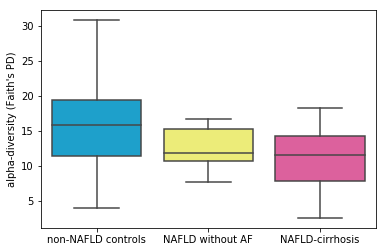

In [6]:
fig, ax = plt.subplots()
fig = sns.boxplot(y='faith_pd', x='groups', order=['G1P', 'G2P', 'G3P'], data=adiv, 
           palette={'G1P':'#01AEE8','G2P':'#ffff66','G3P':'#F04D9C'}, ax=ax)
ax.set(xlabel='', ylabel="alpha-diversity (Faith's PD)")
ax.set_xticklabels(['non-NAFLD controls', 'NAFLD without AF', 'NAFLD-cirrhosis'])
plt.savefig('figures/fig2a.adiv_G1PG2PG3P.pdf', bbox_to_inches='tight')

In [7]:
ag1 = [adiv.loc[idx, 'faith_pd'] for idx in adiv.index if adiv.loc[idx, 'groups'] == 'G1P']
ag2 = [adiv.loc[idx, 'faith_pd'] for idx in adiv.index if adiv.loc[idx, 'groups'] == 'G2P']
ag3 = [adiv.loc[idx, 'faith_pd'] for idx in adiv.index if adiv.loc[idx, 'groups'] == 'G3P']

In [8]:
# kruskal-wallis significance testing
print(kruskal(ag1, ag2))
print(kruskal(ag2, ag3))
print(kruskal(ag1, ag3))

KruskalResult(statistic=5.7630510004513269, pvalue=0.016366628267174482)
KruskalResult(statistic=0.30352941176468562, pvalue=0.58167821017296817)
KruskalResult(statistic=9.4804889228418858, pvalue=0.0020766861584284721)


### 2. plotting trends in beta diversity (unweighted unifrac distances)

In [9]:
uwdm = ssd.DistanceMatrix.read('bdiv9k/unweighted_unifrac_dm.txt')
wdm = ssd.DistanceMatrix.read('bdiv9k/unweighted_unifrac_dm.txt')
sample_arr = (wdm.ids)

In [10]:
# list of samples in each group
sg1 = [idx for idx in sample_arr if md.loc[idx, 'groups'] == 'G1P']
sg2 = [idx for idx in sample_arr if md.loc[idx, 'groups'] == 'G2P']
sg3 = [idx for idx in sample_arr if md.loc[idx, 'groups'] == 'G3P']

In [11]:
# all possible pairs in each group
pg1 = list(itertools.combinations(sg1, 2))
pg2 = list(itertools.combinations(sg2, 2))
pg3 = list(itertools.combinations(sg3, 2))

In [12]:
len(pg3)

300

In [13]:
# unweighted UF distances
uwdg1 = [uwdm[pair] for pair in pg1]
uwdg2 = [uwdm[pair] for pair in pg2]
uwdg3 = [uwdm[pair] for pair in pg3]

In [14]:
# weighted UF distances
wdg1 = [wdm[pair] for pair in pg1]
wdg2 = [wdm[pair] for pair in pg2]
wdg3 = [wdm[pair] for pair in pg3]

In [15]:
#dataframe to plot bdiv
pdf = pd.DataFrame(index=pd.MultiIndex.from_tuples(pg1+pg2+pg3), 
                   columns=['unweighted_unifrac','weighted_unifrac', 'groups'])
# assign groups
pdf.groups=['G1P']*len(pg1)+['G2P']*len(pg2)+['G3P']*len(pg3)

# assign distances
pdf.unweighted_unifrac=uwdg1+uwdg2+uwdg3
pdf.weighted_unifrac=wdg1+wdg2+wdg3

In [16]:
#save source data
pdf.to_csv('tables/source_data_beta_diversity_fig2b.csv')

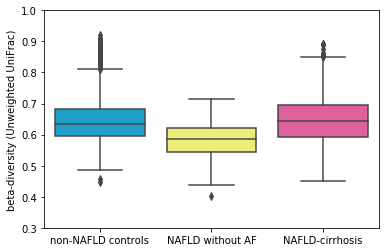

In [17]:
fig, ax = plt.subplots()
sns.boxplot(y='unweighted_unifrac', x='groups', order=['G1P', 'G2P', 'G3P'], data=pdf, 
           palette={'G1P':'#01AEE8','G2P':'#ffff66','G3P':'#F04D9C'}, ax=ax)
ax.set(xlabel='', ylabel="beta-diversity (Unweighted UniFrac)")
ax.set_xticklabels(['non-NAFLD controls', 'NAFLD without AF', 'NAFLD-cirrhosis'])
ax.set_ylim([0.3, 1])
plt.savefig('figures/fig2b.bdiv_unweighted_G1PG2PG2P.pdf', bbox_to_inches='tight')

In [18]:
bg1 = [pdf.loc[idx, 'unweighted_unifrac'] for idx in pdf.index if pdf.loc[idx, 'groups'] == 'G1P']
bg2 = [pdf.loc[idx, 'unweighted_unifrac'] for idx in pdf.index if pdf.loc[idx, 'groups'] == 'G2P']
bg3 = [pdf.loc[idx, 'unweighted_unifrac'] for idx in pdf.index if pdf.loc[idx, 'groups'] == 'G3P']

print(kruskal(bg1, bg2))
print(kruskal(bg2, bg3))
print(kruskal(bg1, bg3))

KruskalResult(statistic=77.792211102070723, pvalue=1.1447066799586784e-18)
KruskalResult(statistic=62.065963790550541, pvalue=3.3214285379151087e-15)
KruskalResult(statistic=1.6947850900769481, pvalue=0.19297138819839121)
